File read successfully. Number of rows: 5565
Number of rows after dropping nulls: 5555
Number of training samples: 3964
Number of test samples: 1591
RowMatrix size: 3964 rows, 10 columns
Selected columns: [0, 2, 6, 7]
Selected rows: [121, 528, 2978, 3699, 3818]
RowMatrix size: 1591 rows, 10 columns
Selected columns: [0, 1, 2, 5, 6]
Selected rows: [10, 483, 1297, 1338, 1529]
Evaluation results:
R2:
  Original Data - Training: 0.9991
  Original Data - Test: 0.9994
  Reduced Data - Training: 0.9995
  Reduced Data - Test: 0.9995
RMSE:
  Original Data - Training: 0.4330
  Original Data - Test: 0.3713
  Reduced Data - Training: 0.3176
  Reduced Data - Test: 0.3423
MAE:
  Original Data - Training: 0.2138
  Original Data - Test: 0.1910
  Reduced Data - Training: 0.1440
  Reduced Data - Test: 0.1568


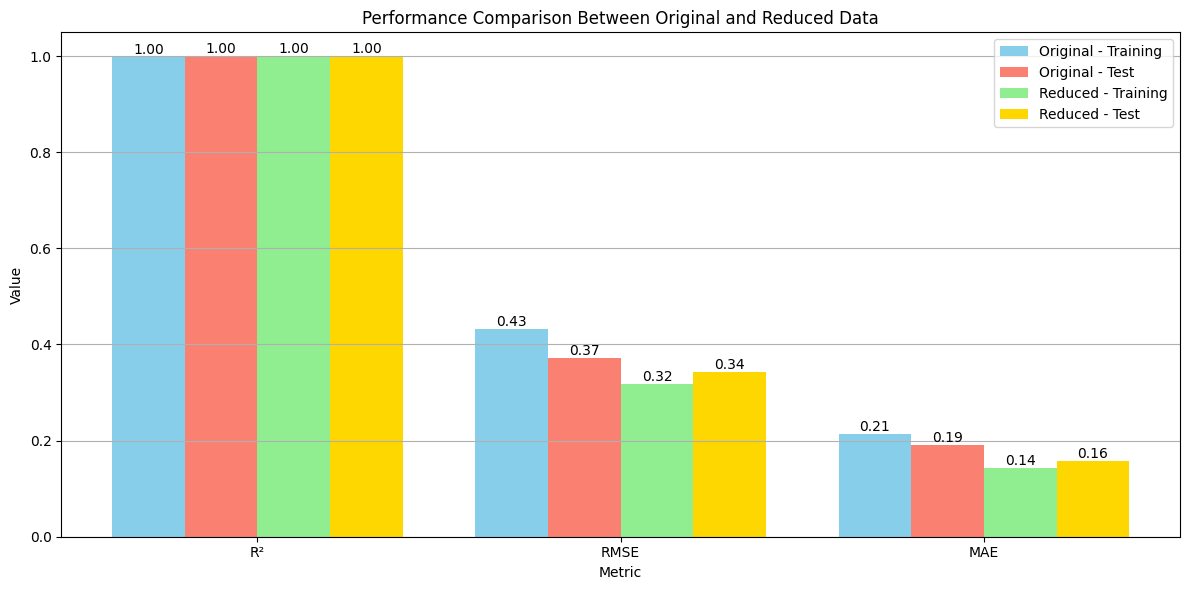

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, randn
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import numpy as np
import random

# Initialize Spark
spark = SparkSession.builder.appName("CURDimensionalityReduction").getOrCreate()

try:
    # 1. Read data
    df = spark.read.csv("gold_prices.csv", header=True, inferSchema=True)
    df = df.withColumn("Date", col("Date").cast("date"))
    df = df.withColumn("Buy Price", col("Buy Price").cast("float"))
    df = df.withColumn("Sell Price", col("Sell Price").cast("float"))
    print(f"File read successfully. Number of rows: {df.count()}")

    # Cache DataFrame for optimization
    df.cache()

    # 2. Create lag features (10 previous days)
    window = Window.orderBy("Date")
    for i in range(1, 11):
        df = df.withColumn(f"lag_{i}", lag("Buy Price", i).over(window))
        df = df.withColumn(f"lag_{i}", col(f"lag_{i}") + randn() * 0.01)  # Add noise
    df = df.na.drop()
    print(f"Number of rows after dropping nulls: {df.count()}")

    # 3. Assemble lag columns into a feature vector
    feature_cols = [f"lag_{i}" for i in range(1, 11)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df = assembler.transform(df)

    # Standardize features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaler_model = scaler.fit(df)
    df = scaler_model.transform(df)

    # Select necessary columns
    df = df.select("Date", "scaled_features", col("Buy Price").alias("label")).withColumnRenamed("scaled_features", "features")

    # 4. Split data 70-30
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)
    print(f"Number of training samples: {train_df.count()}")
    print(f"Number of test samples: {test_df.count()}")

    # 5. CUR Decomposition class
    class CURDecomposition:
        def __init__(self, k, spark_context):
            self.k = k
            self.sc = spark_context

        def compute_leverage_scores(self, matrix, axis="rows"):
            try:
                # Compute SVD
                svd = matrix.computeSVD(self.k, computeU=True)
                if axis == "rows":
                    U = svd.U
                    row_leverage = U.rows.map(lambda row: sum(x * x for x in row.toArray()))
                    total = row_leverage.sum()
                    if total == 0:
                        return row_leverage.map(lambda x: 1.0 / matrix.numRows())
                    return row_leverage.map(lambda x: x / total)
                else:
                    V = svd.V.toArray()
                    col_leverage = np.sum(V * V, axis=1)
                    total = col_leverage.sum()
                    if total == 0:
                        col_leverage = np.ones(matrix.numCols()) / matrix.numCols()
                    else:
                        col_leverage = col_leverage / total
                    return self.sc.parallelize([float(col_leverage[i]) for i in range(len(col_leverage))])
            except Exception as e:
                print(f"Error while computing leverage scores ({axis}): {e}")
                return self.sc.parallelize([1.0 / (matrix.numRows() if axis == "rows" else matrix.numCols())] *
                                         (matrix.numRows() if axis == "rows" else matrix.numCols()))

        def select_columns(self, matrix):
            col_leverage = self.compute_leverage_scores(matrix, axis="columns")
            indices = list(range(matrix.numCols()))
            probs = col_leverage.collect()
            if len(probs) != len(indices):
                print(f"Error: Number of probs ({len(probs)}) does not match number of columns ({len(indices)})")
                probs = [1.0 / len(indices)] * len(indices)
            total_prob = sum(probs)
            if total_prob == 0:
                probs = [1.0 / len(probs)] * len(probs)
            else:
                probs = [p / total_prob for p in probs]
            selected_cols = random.choices(indices, weights=probs, k=self.k)
            return sorted(set(selected_cols))

        def select_rows(self, matrix):
            row_leverage = self.compute_leverage_scores(matrix, axis="rows")
            indices = list(range(matrix.numRows()))
            probs = row_leverage.collect()
            if len(probs) != len(indices):
                print(f"Error: Number of probs ({len(probs)}) does not match number of rows ({len(indices)})")
                probs = [1.0 / len(indices)] * len(indices)
            total_prob = sum(probs)
            if total_prob == 0:
                probs = [1.0 / len(probs)] * len(probs)
            else:
                probs = [p / total_prob for p in probs]
            selected_rows = random.choices(indices, weights=probs, k=self.k)
            return sorted(set(selected_rows))

        def fit_transform(self, matrix):
            row_matrix = RowMatrix(matrix.map(lambda v: list(v.toArray())))
            print(f"RowMatrix size: {row_matrix.numRows()} rows, {row_matrix.numCols()} columns")

            selected_cols = self.select_columns(row_matrix)
            selected_rows = self.select_rows(row_matrix)
            print(f"Selected columns: {selected_cols}")
            print(f"Selected rows: {selected_rows}")

            matrix_np = np.array(row_matrix.rows.map(lambda row: row.toArray()).collect())
            C = matrix_np[:, selected_cols]
            R = matrix_np[selected_rows, :]
            W = matrix_np[np.ix_(selected_rows, selected_cols)]
            U = np.linalg.pinv(W)
            new_representation = np.dot(C, np.dot(U, R))
            new_rdd = self.sc.parallelize([Vectors.dense(row) for row in new_representation[:, :self.k]])
            return new_rdd

    # 6. Prepare feature matrix for CUR
    train_features_rdd = train_df.select("features").rdd.map(lambda row: row.features)
    test_features_rdd = test_df.select("features").rdd.map(lambda row: row.features)

    # Apply CUR for dimensionality reduction
    random.seed(42)
    cur = CURDecomposition(k=5, spark_context=spark.sparkContext)
    train_reduced_rdd = cur.fit_transform(train_features_rdd)
    test_reduced_rdd = cur.fit_transform(test_features_rdd)

    # Convert reduced data to DataFrame
    train_labels = train_df.select("label").rdd.map(lambda r: r.label)
    train_reduced_rdd = train_reduced_rdd.repartition(train_labels.getNumPartitions())
    train_reduced_df = spark.createDataFrame(
        train_reduced_rdd.zip(train_labels),
        schema=["features", "label"]
    )

    test_labels = test_df.select("label").rdd.map(lambda r: r.label)
    test_reduced_rdd = test_reduced_rdd.repartition(test_labels.getNumPartitions())
    test_reduced_df = spark.createDataFrame(
        test_reduced_rdd.zip(test_labels),
        schema=["features", "label"]
    )

    # 7. Train model on reduced data
    lr_reduced = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01, elasticNetParam=0.5, solver="l-bfgs")
    model_reduced = lr_reduced.fit(train_reduced_df)
    train_reduced_preds = model_reduced.transform(train_reduced_df)
    test_reduced_preds = model_reduced.transform(test_reduced_df)

    # 8. Train model on original data
    lr_original = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01, elasticNetParam=0.5, solver="l-bfgs")
    model_original = lr_original.fit(train_df)
    train_original_preds = model_original.transform(train_df)
    test_original_preds = model_original.transform(test_df)

    # 9. Compare performance
    metrics = ["r2", "rmse", "mae"]
    results = {
        "original_train": [],
        "original_test": [],
        "reduced_train": [],
        "reduced_test": []
    }
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
    for metric in metrics:
        evaluator.setMetricName(metric)
        results["original_train"].append(evaluator.evaluate(train_original_preds))
        results["original_test"].append(evaluator.evaluate(test_original_preds))
        results["reduced_train"].append(evaluator.evaluate(train_reduced_preds))
        results["reduced_test"].append(evaluator.evaluate(test_reduced_preds))

    # Print results
    print("Evaluation results:")
    for metric in metrics:
        print(f"{metric.upper()}:")
        print(f"  Original Data - Training: {results['original_train'][metrics.index(metric)]:.4f}")
        print(f"  Original Data - Test: {results['original_test'][metrics.index(metric)]:.4f}")
        print(f"  Reduced Data - Training: {results['reduced_train'][metrics.index(metric)]:.4f}")
        print(f"  Reduced Data - Test: {results['reduced_test'][metrics.index(metric)]:.4f}")

    # 10. Plot bar chart for comparison
    bar_width = 0.2
    index = np.arange(len(metrics))
    plt.figure(figsize=(12, 6))
    bars_original_train = plt.bar(index, results["original_train"], bar_width, label="Original - Training", color="skyblue")
    bars_original_test = plt.bar(index + bar_width, results["original_test"], bar_width, label="Original - Test", color="salmon")
    bars_reduced_train = plt.bar(index + 2 * bar_width, results["reduced_train"], bar_width, label="Reduced - Training", color="lightgreen")
    bars_reduced_test = plt.bar(index + 3 * bar_width, results["reduced_test"], bar_width, label="Reduced - Test", color="gold")
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.title("Performance Comparison Between Original and Reduced Data")
    plt.xticks(index + 1.5 * bar_width, ["R²", "RMSE", "MAE"])
    plt.legend()
    plt.grid(True, axis="y")
    # Add values on top of bars
    for bars in [bars_original_train, bars_original_test, bars_reduced_train, bars_reduced_test]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig("cur_comparison_updated.png")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    spark.stop()